# HPC Mini-Challenge 2 - Beschleunigung in Data Science
#### FHNW - FS2022

Original von S. Suter, angepasst für das HS22 von S. Marcin

### Ressourcen
* HPC mit Python – days 1-2 ([Videos](https://www.youtube.com/playlist?list=PL1tk5lGm7zvSC4rLm5Y71372R1Yxl2Dg_), [Github](https://github.com/eth-cscs/PythonHPC)), 2020:
    - JupyterLab Tutorial (z.B. GPU Ressourcen)
    - Introduction
    - Vectorization
    - Profiling
    - JIT Numba CPU 1 + 2
    - Siehe auch aktuelles Tutorial von 2021

Abgabe von: <font color='blue'>Name hier eintragen</font>


## Ausgangslage/Problemstellung


Das menschliche Gehirn verliert mit zunehmendem Alter an Funktion. Ein Teil davon ist "gesundes Altern", d.h. es passiert bei jedem Menschen. Ein relativ großer Prozentsatz der alternden Bevölkerung erlebt jedoch auch einen kognitiven Rückgang, der extremer ist als bei anderen. Eine mildere Version davon wird als 'leichte kognitive Beeinträchtigung' (MCI) bezeichnet, bei der die Person grösstenteils noch funktionieren kann. Bei einem Teil der MCI-Patienten schreitet die Krankheit fort und führt zu Demenz bzw. Alzheimer. In diesem Projekt liegen uns MRI-Bilder des Gehirns von Alzheimerpatienten vor. Im spezifischen analysieren wir die Entwicklung von Alzheimer-Patienten anhand von MRI-Bildern, welche über eine bestimmte Zeit zur Verfügung stehen. Es stellt sich die Frage, wie gut sich die Veränderungen des Krankheitsbildes mittels Korrelationen über die Bildanalyse zeigen lassen. Zur Analyse sind Gigabytes von Daten in Form von 3D Gehirn-Scans vorhanden. Die Verarbeitung dieser grossen Datenmengen kann von Komprimierung profitieren.

Das Verständnis von Gedächtnis- und Kognitionsstörungen und die Möglichkeit, den Gesundheitszustand des Gehirns zu erkennen, vorherzusagen und zu überwachen, ist ein gesellschaftlich und wirtschaftlich relevantes Thema der angewandten Wissenschaft. Alle neuen Erkenntnisse, die datenwissenschaftliche Methoden liefern können, werden zur Entwicklung von Lösungen beitragen, mit denen die Gesundheit des Gehirns erkannt, vorhergesagt und überwacht werden kann.

### Daten
[ADNI (Alzheimer's Disease Neuroimaging Initiative)](https://adni.loni.usc.edu/) ist ein internationales Projekt zur Erfassung von Daten über die Alzheimer-Krankheit und andere verwandte Gehirnerkrankungen, die zu einem kognitiven Abbau führen. Die Initiative wurde mit grossem Enthusiasmus aufgenommen, und viele Mitarbeiter aus der ganzen Welt haben Daten zur Verfügung gestellt, die sie in ihren eigenen Forschungsteams gesammelt haben. Die ADNI-Initiative ist ein öffentliches (gemeinnütziges) Projekt, da viele Forschungseinrichtungen auf der ganzen Welt mit Steuergeldern dazu beigetragen haben. Das bedeutet zwei Dinge: 1) Die Daten stehen uns für Forschungs- und Bildungszwecke zur Verfügung, 2) wir dürfen die Daten nicht an andere weitergeben oder kommerzialisieren.



***Wichtig!*** Die Studierenden dürfen die Daten nur für Forschungszwecke verwenden und erhalten nur einen Beispielsdatensatz. Die ADNI-Daten dürfen nur lokal auf dem Computer oder auf FHNW-Ressourcen wie dem GitLab-Repository, d.h. nicht auf Github, gespeichert werden. Siehe [ADNI Datennutzungsvereinbarung](https://adni.loni.usc.edu/wp-content/uploads/how_to_apply/ADNI_Data_Use_Agreement.pdf).


<img src="images/mri-example.png" alt="MRI example image (coronal slice)" width="150"/> <img src="images/slicing.png" alt="Slicing" width="400"/>

Links: MRI Beispielbild (coronaler Schnitt), rechts: MRI slicing

## Zielsetzung

In dieser Aufgabe sollen die Parallelisierung und Beschleunigung unterschiedlicher Methoden von Bildrekonstruktion basierend auf komprimierten (zerlegten) Daten implementiert, analyisiert und diskutiert werden. Die Rekonstruktion der Daten aus der komprimierten Version soll dabei möglichst in Echtzeit geschehen. 

## Lösungsweg / Vorgehen

Wir lösen diese Aufgabenstellung indem wir die Singulärwertzerlegung (SVD: singular value decomposition) als Kompressionsmethode verwenden (Matrixfaktorisierung). Siehe Abbildungen unten. Um die Rekonstruktion der Daten aus der SVD-Matrixfaktoriseriung möglichst in Echtzeit zu bewerkstelligen, evaluieren wir dafür verschiedene Methoden der Parallelisierung und Beschleunigung in Python. 
* Beschleunigungsvarianten auf der CPU:
    - Numpy Operationen inkl. Broadcasting
    - Numba
    - Threads
* Beschleunigung auf der GPU:
    - Cupy (analog zu Numpy)
    - Numba (analog zu Numba)

<img src="images/svd_reco.png" alt="svd vis" width="300"/> <img src="images/svd.png" alt="svd" width="300"/>

## Daten Zerlegen
### 1.1 Daten laden


In [1]:
import os
import imageio
import numpy as np

subfolder = '001'
folders = os.path.join('adni_png', subfolder)

images = np.empty([4,256,170])
idx = 0
names = []
for filename in os.listdir(folders):
    if filename.endswith('.png') and '145' in filename:
        with open(os.path.join(folders, filename), 'r') as f:
            if idx < images.shape[0]:
                im = imageio.imread(f.name)
                names.insert(idx,f.name[-17:-4])
                images[idx,:,:] = im
                print (names[idx], im.shape)
                idx += 1
            
print(images.shape)

m1-2_slice145 (256, 170)
m3-2_slice145 (256, 170)
m4-2_slice145 (256, 170)
m3-1_slice145 (256, 170)
(4, 256, 170)


/var/folders/mw/x398f5s545bffd989r6xpm100000gp/T/ipykernel_11874/4025362909.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(f.name)


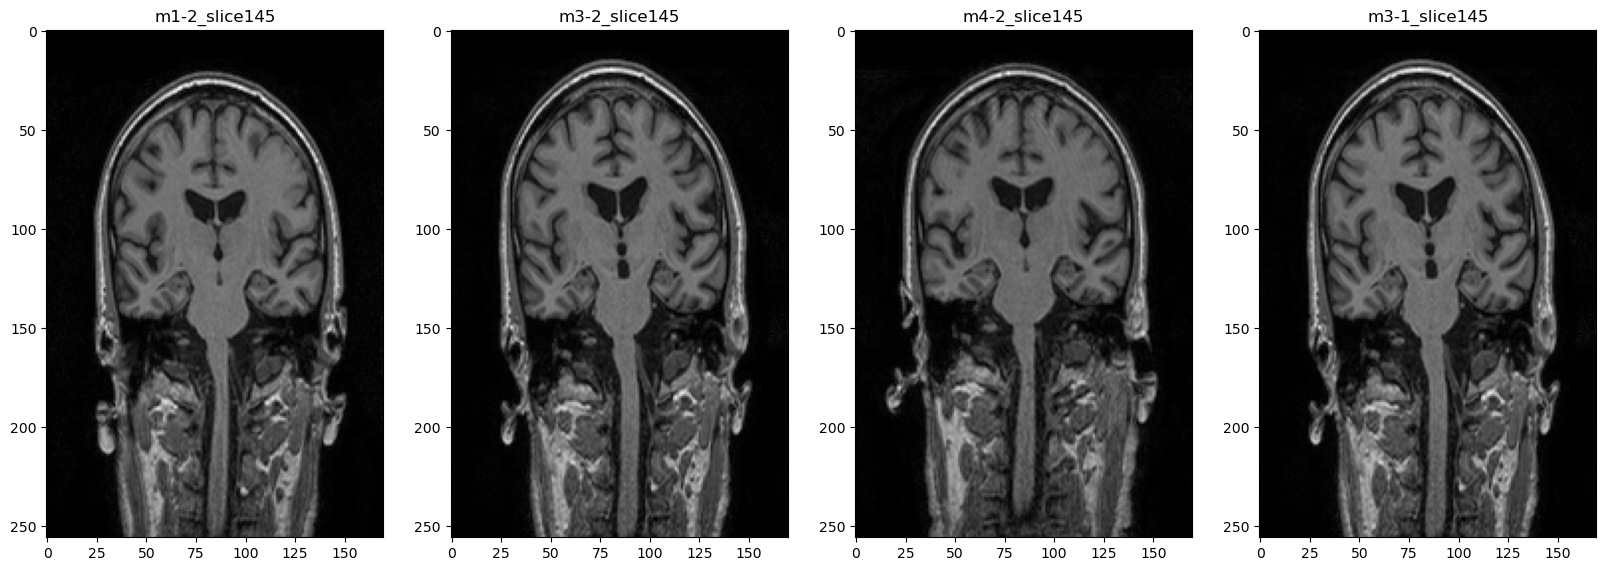

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20,10))

for a in range(images.shape[0]):
    ax = fig.add_subplot(1, images.shape[0],a+1)
    ax.imshow(images[a],cmap='gray')
    ax.set_title(names[a])


### 1.2 Daten zerlegen

In [3]:
im = images[0]
im = im -im.min() / im.max() - im.min() # normalize data 
u,s,vt = np.linalg.svd(im, full_matrices=False)

In [4]:
def reconstruct_svd(u,s,vt,k):
    """SVD reconstruction for k components using np.dot()
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    reco = np.dot(u[...,:k], np.dot(np.diag(s[:k]), vt[:k,...]))
        
    return reco

In [5]:
from skimage import metrics

# calculate various metrics for the reconstruction quality
def calculate_metrics(im, reco):
    mse = metrics.mean_squared_error(im, reco)
    ssim_score = metrics.structural_similarity(im, reco, data_range=reco.max()-reco.min())
    hdist = metrics.hausdorff_distance(im, reco)
    return f"MSE: {mse:.2f},\n SSIM {ssim_score:.2f},\n HDIST: {hdist:.2f}"


original size:  43520
decomposed to n =  170 , size:  72590
decomposed to n =  140 , size:  59780
decomposed to n =  110 , size:  46970
decomposed to n =  80 , size:  34160
decomposed to n =  50 , size:  21350


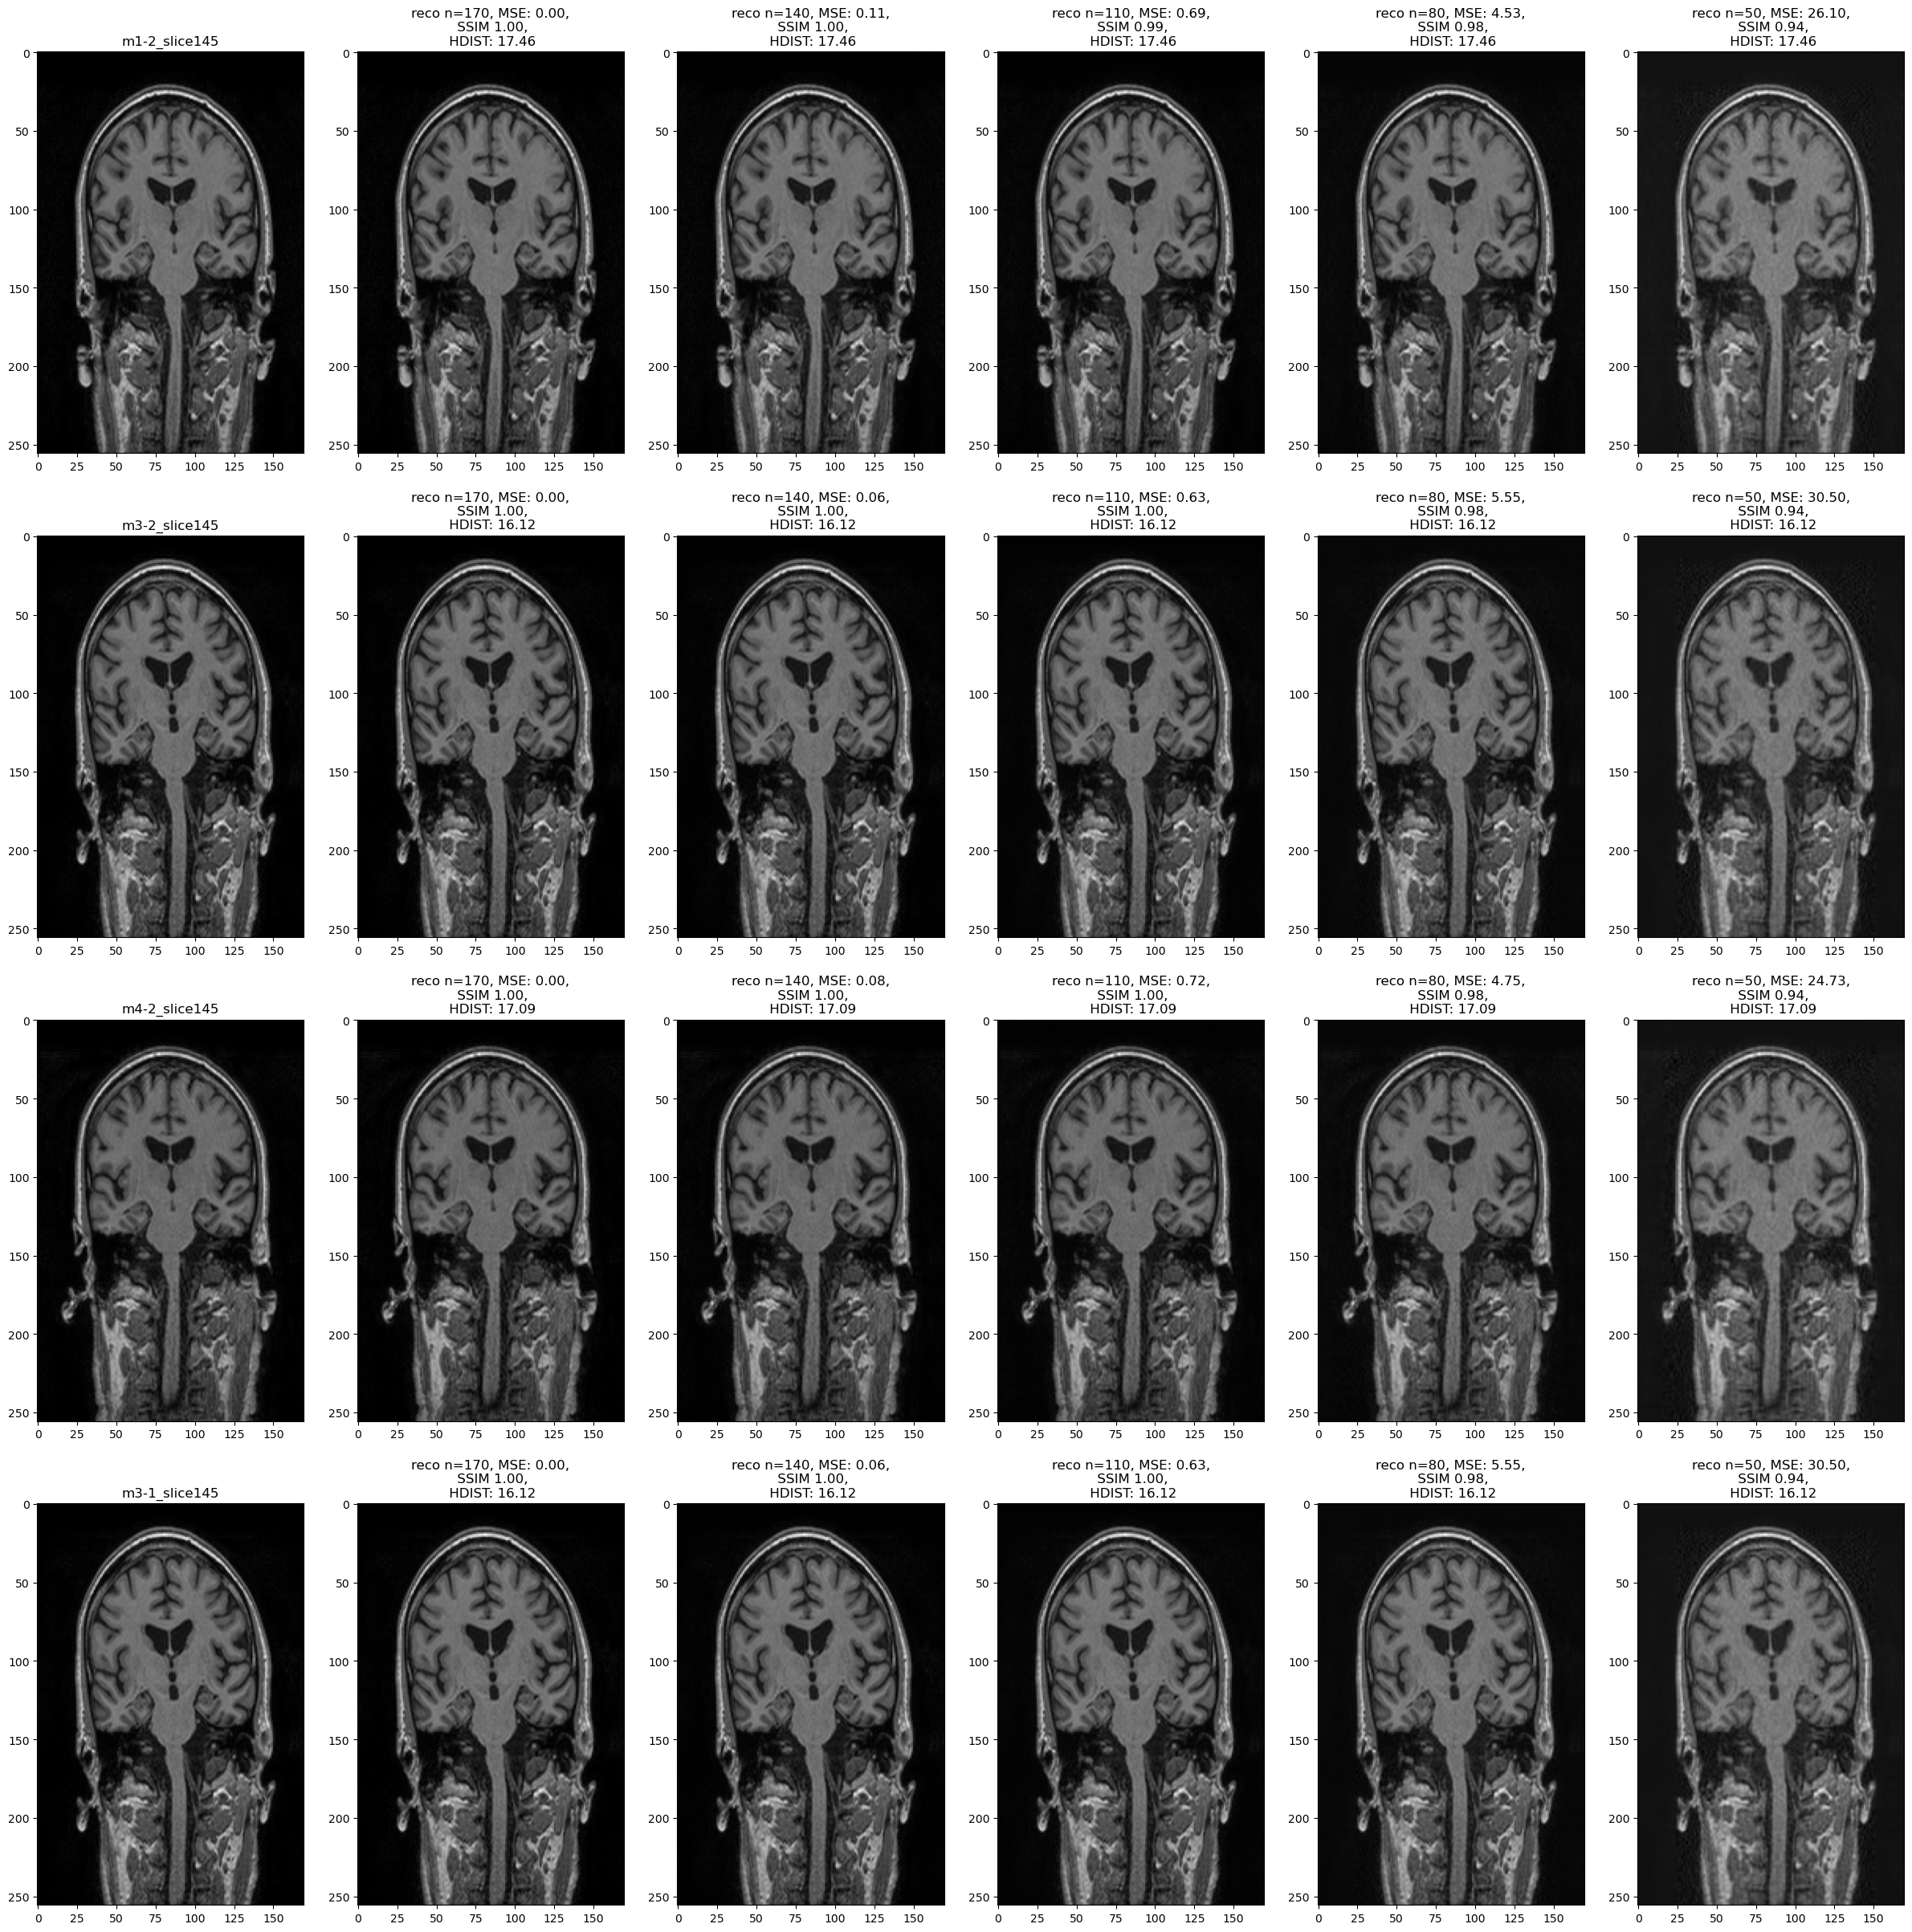

In [6]:
fig, axs = plt.subplots(images.shape[0], 6, figsize=(30,30))

for a in range(images.shape[0]):
    im = images[a]
    im = im -im.min() / im.max() - im.min()    
    u,s,vt = np.linalg.svd(im, full_matrices=False)

    axs[a, 0].imshow(im,cmap='gray')
    axs[a, 0].set_title(names[a])
    
    if (a == 0):
        print('original size: ', im.shape[0]*im.shape[1])
    
    for idx, n in enumerate(range(s.shape[0], 20, -30)):
        reco = reconstruct_svd(u,s,vt,n)
        if (a == 0):
            print('decomposed to n = ', n , ', size: ', u.shape[0] * n + n + vt.shape[0]*n)
    
        axs[a, idx+1].imshow(reco,cmap='gray')
        axs[a, idx+1].set_title('reco n=' + str(n) + ', ' + calculate_metrics(im, reco))
    

### 2 Rekonstruktionsvarianten
Siehe Bilder in der Einführung (Teil: Vorgehen).

In [7]:
# helper function to visualze reconstruction
def plot_reco(reco, k):
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(reco,cmap='gray')
    ax.set_title('reco with ' + str(k)+ ' components')

#### 2.1 For-Loops
Rekonstruiere nun die zerlegte SVD Matrix mittels For-Loops gemäss Formel B.4 (oben). Rekonstruiere nur die ersten $k$ Komponenten der SVD-Matrixfaktorisierung $U, S, V^T$, wobei $U \in \mathbb{R}^{MxN}$, $S \in \mathbb{R}^{N}$, und  $V^T \in \mathbb{R}^{NxN}$. 

Implementiere dafür folgende drei Funktionen - jeweils mit 3, 2 bzw. 1 For-Loop:

In [8]:
def reconstruct_svd_for_loops3(U,S,Vt,k):
    """SVD reconstruction for k components using 3 for-loops
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    M, N = U.shape
    reconstructed_matrix = np.zeros((M, N))
    for i in range(M):
        for j in range(N):
            for l in range(k):
                reconstructed_matrix[i,j] += U[i,l] * S[l] * Vt[l,j]
    return reconstructed_matrix
    ### END SOLUTION

In [9]:
def reconstruct_svd_for_loops2(U,S,Vt,k):
    """SVD reconstruction for k components using 2 for-loops
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    M, N = U.shape
    reconstructed_matrix = np.zeros((M, N))
    for i in range(M):
        for l in range(k):
            reconstructed_matrix[i,:] += U[i,l] * S[l] * Vt[l,:]
    return reconstructed_matrix
    ### END SOLUTION

In [10]:
def reconstruct_svd_for_loops1(U,S,Vt,k):
    """SVD reconstruction for k components using 1 for-loop and np.outer()
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    M, N = U.shape
    reconstructed_matrix = np.zeros((M, N))
    for l in range(k):
        reconstructed_matrix += U[:,l][:,np.newaxis] * S[l] * Vt[l,:][np.newaxis,:]
    return reconstructed_matrix
    ### END SOLUTION

#### 2.2 Einstein Summation
Implementiere nun eine möglichst schnelle Rekonstruktionsvariante mittels `np.einsum()` gemäss folgender Funktion:

In [11]:
def reconstruct_svd_einsum1(u,s,vt,k):
    """SVD reconstruction for k components using broadcast
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    return np.einsum('ij,j,jk->ik', u[:, :k], s[:k], vt[:k, :])
    ### END SOLUTION

#### 2.3 Broadcasting
Implementiere nun zwei Rekonstruktionsvarianten mittels Broadcasting.

Links:
- https://machinelearningmastery.com/broadcasting-with-numpy-arrays/
- https://numpy.org/doc/stable/user/basics.broadcasting.html
- https://eli.thegreenplace.net/2015/broadcasting-arrays-in-numpy/
- https://scipy.github.io/old-wiki/pages/EricsBroadcastingDoc

In [12]:
def reconstruct_svd_broadcast1(u, s, vt, k):
    """SVD reconstruction for k components using broadcast variant 1
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    
    # Extract the first k rows of matrices s and vt
    s_k = s[:k]
    vt_k = vt[:k, :]
    
    # Multiply u and s_k
    us_k = u[:, :k] * s_k
    
    # Multiply the result with vt_k using broadcasting
    u_s_vt = us_k @ vt_k
    return u_s_vt

    ### END SOLUTION


In [13]:
def reconstruct_svd_broadcast2(u, s, vt, k):
    """SVD reconstruction for k components using broadcast variant 2
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    
    # Create a diagonal matrix (k, k) using the first k elements of s
    s_k = np.diag(s[:k])
    
    # Create a (n, k) matrix by extracting the first k columns of u
    u_k = u[:, :k]
    
    # Create a (k, n) matrix by extracting the first k rows of vt
    vt_k = vt[:k, :]
    
    u_s_vt = u_k @ s_k @ vt_k
    return u_s_vt

    ### END SOLUTION



#### 2.4 Vergleich der Resultate
Vergleiche die Resultate der Implementierungen anhand eines Beispielbildes. Sind die Rekonstruktionen nahezu gleich? Wie sieht es mit der Rekonstruktionsgeschwindigkeit aus - abhängig von der Anzahl rekonstruierter Komponenten?

In [14]:
### BEGIN SOLUTION
from skimage import data, color
import numpy as np
from time import time

# load example image and convert to grayscale
img = color.rgb2gray(data.astronaut())

# perform SVD factorization
u, s, vt = np.linalg.svd(img)

# define number of components to reconstruct
n_components = [2, 10, 50, 100, 200]

# define implementation functions
implementations = {
    'for-loop2': reconstruct_svd_for_loops2,
    'for-loop3': reconstruct_svd_for_loops3,
    'for-loop1': reconstruct_svd_for_loops1,
    'einsum': reconstruct_svd_einsum1,
    'broadcast 1': reconstruct_svd_broadcast1,
    'broadcast 2': reconstruct_svd_broadcast2,
}

# initialize results dict
img_results = {}
time_results = {}

# loop over implementations
for impl_name, impl_func in implementations.items():
    
    # initialize times list
    times = []
    
    # loop over number of components
    for k in n_components:
        
        # start timer
        t_start = time()
        
        # perform reconstruction
        try:
            reco = impl_func(u, s, vt, k)
        except Exception as e:
            print(f'Error in {impl_name} for k={k}!')
            raise e
        
        # end timer
        t_end = time()
        
        # calculate elapsed time
        t_elapsed = t_end - t_start
        
        # append time to times list
        times.append(t_elapsed)
        
        # store reconstruction result in results dict
        if impl_name not in img_results:
            img_results[impl_name] = {}
        img_results[impl_name][k] = reco

        if impl_name not in time_results:
            time_results[impl_name] = {}
        time_results[impl_name][k] = t_elapsed
    
    # print times for current implementation
    print(f'{impl_name}: {times}')

### END SOLUTION

for-loop2: [0.0017659664154052734, 0.025021791458129883, 0.04787397384643555, 0.09116530418395996, 0.1471700668334961]
for-loop3: [0.19933319091796875, 0.8994171619415283, 4.322761297225952, 8.580295085906982, 17.177999258041382]
for-loop1: [0.0008840560913085938, 0.0033059120178222656, 0.018508195877075195, 0.03583216667175293, 0.07148027420043945]
einsum: [0.0005619525909423828, 0.0016770362854003906, 0.00808095932006836, 0.01613473892211914, 0.03136634826660156]
broadcast 1: [0.00418400764465332, 0.0004489421844482422, 0.0010437965393066406, 0.001138925552368164, 0.0034356117248535156]
broadcast 2: [0.0004558563232421875, 0.0006158351898193359, 0.0006301403045654297, 0.008814096450805664, 0.0043849945068359375]


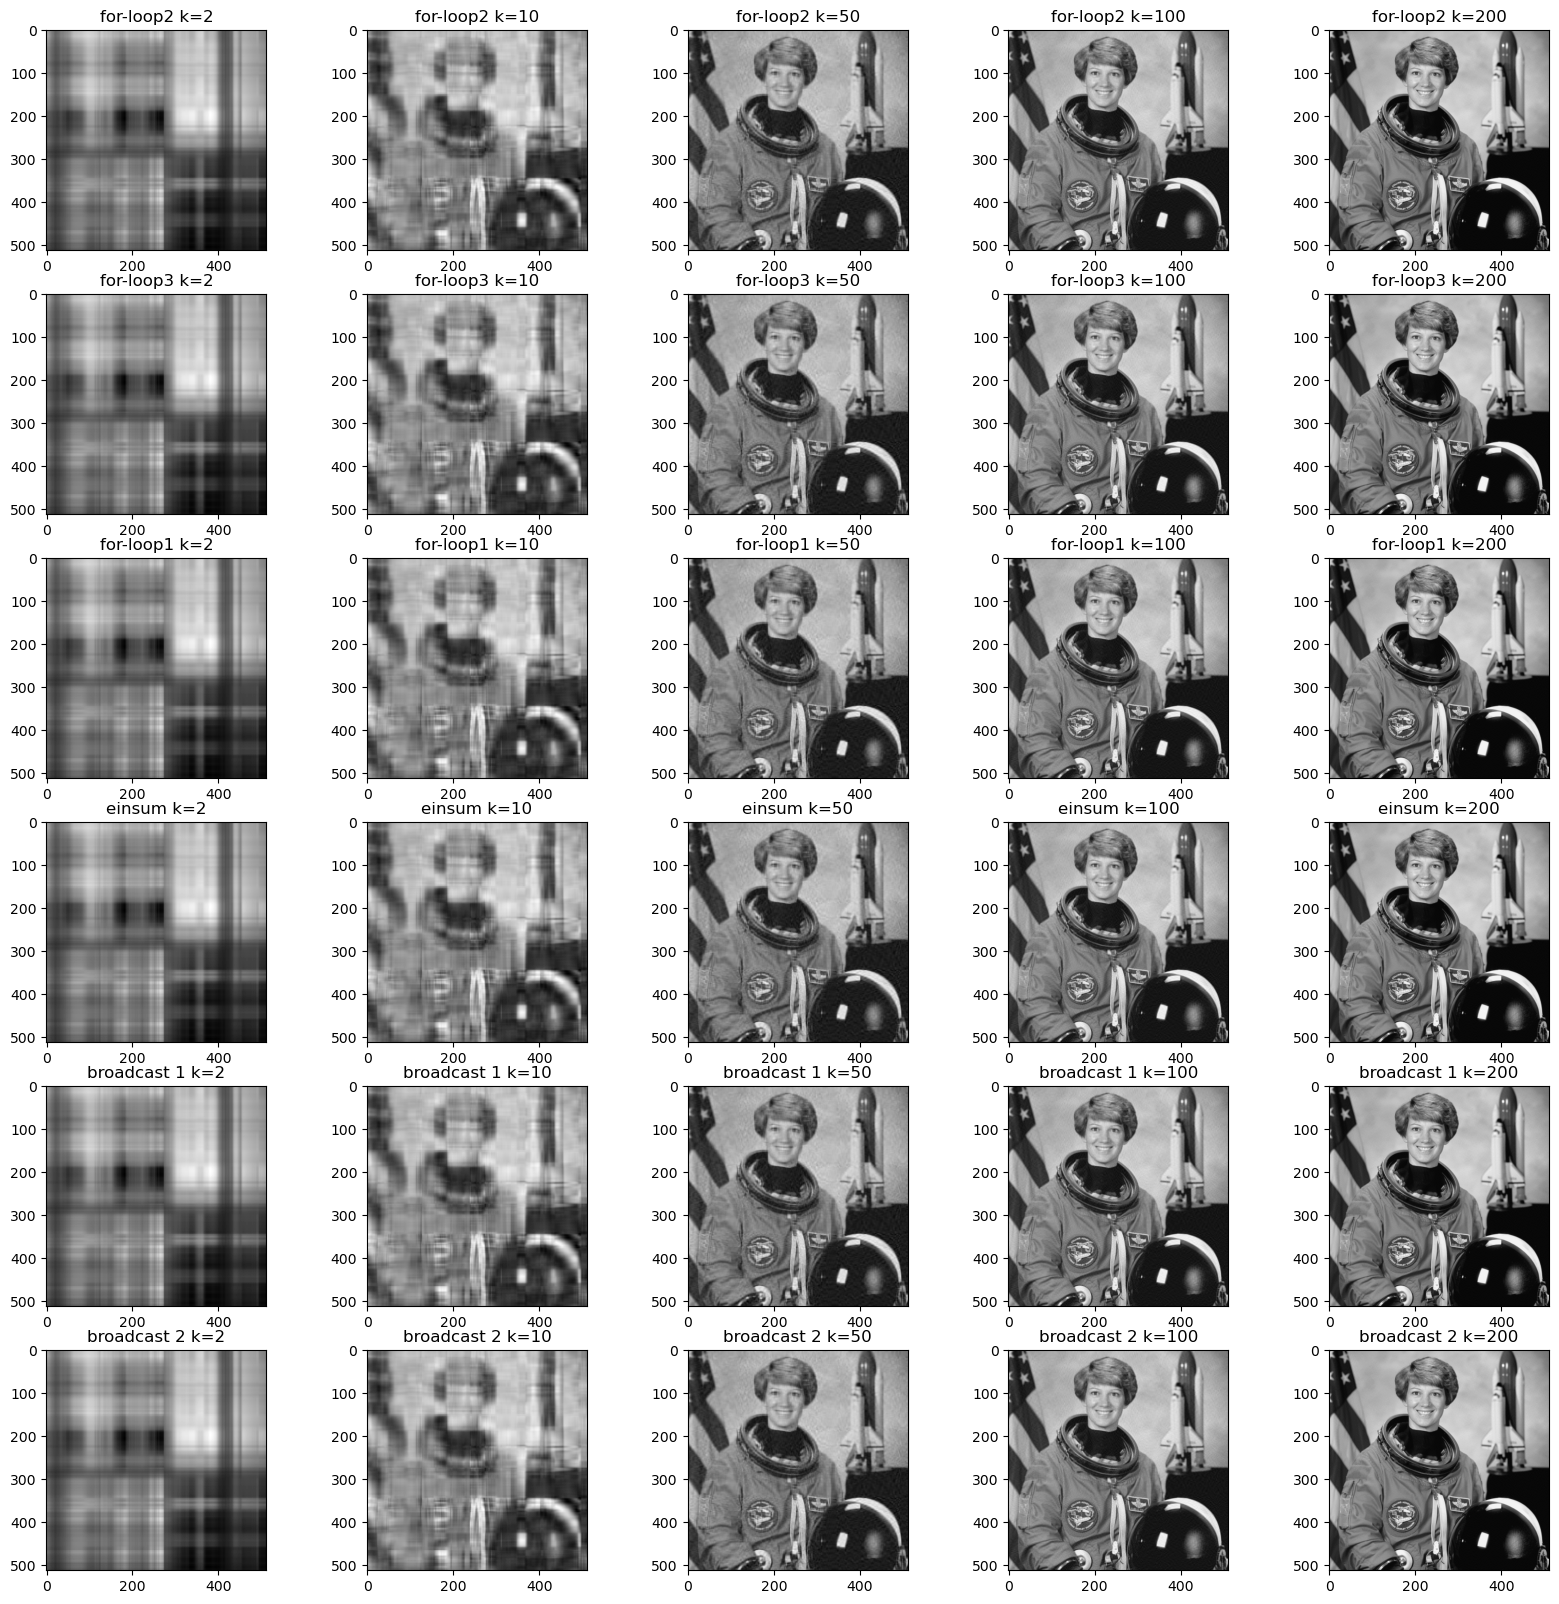

In [15]:
fig, axs = plt.subplots(6, 5, figsize=(20, 20))
for i, (impl_name, impl_result) in enumerate(img_results.items()):
    for j, (k, result) in enumerate(impl_result.items()):
        axs[i, j].imshow(result, cmap='gray')
        axs[i, j].set_title(f'{impl_name} k={k}')
plt.show()

In [16]:
plt.plot(n_components, [time_results['for-loop2'][k] for k in n_components], label='for-loop2')
plt.plot(n_components, [time_results['for-loop3'][k] for k in n_components], label='for-loop3')
plt.plot(n_components, [time_results['for-loop1'][k] for k in n_components], label='for-loop1')
plt.plot(n_components, [time_results['einsum'][k] for k in n_components], label='einsum')
plt.plot(n_components, [time_results['broadcast 1'][k] for k in n_components], label='broadcast 1')
plt.plot(n_components, [time_results['broadcast 2'][k] for k in n_components], label='broadcast 2')
plt.legend()
plt.xlabel('Number of components')
plt.ylabel('Time (s)')
plt.show()

#### 2.5 Interpretation der Resultate

Welche der Implementierungen war am schnellsten? Was waren deine Beobachtungen während der Implementierung? Wo können solche Optimierungen sonst noch eingesetzt werden? Diskutiere in ca. 150-200 Wörtern.<br />
<font color=red>
Die Rekonstruktionen mit diversen Implementierungen sehen gleich aus.<br />
Die benötigte Zeit war bei allen Methoden recht ähnlich, außer bei der Methode, die 3 for-Schleifen zur Berechnung der Rekonstruktion verwendete.
Bei der Methode mit 3 for-Schleifen zeigt sich eine lineare Laufzeit für eine höhere Anzahl von Komponenten.
Bei den anderen Methoden ist die Laufzeit bei einer höheren Anzahl von Komponenten annähernd konstant.
Am aussagekräftigsten waren die Broadcasting-Methoden, da sie mathematischen Gleichungen ähneln und daher am besten lesbar sind.
Die Einsum-Methode ist eine höhere Abstraktionsebene wie np.svd() und daher nicht so verständlich wie die Broadcasting-Implementierungen.
Einsum- und Broadcasting-Methoden können in einer Vielzahl von Anwendungen eingesetzt werden, z.B. in der Physik zur Berechnung der Energie eines Systems oder in der natürlichen Sprachverarbeitung zur Berechnung der Ähnlichkeit zwischen zwei Vektoren.
<font>

### 3 Parallelisierung mittels Numba

Implementiere nun eine möglichst schnelle Rekonstruktionsvariante des SVDs mittels Numba. Ist es möglich, den Code mit Numba zu beschleunigen? Führe dazu eine Diagnostik aus. Wenn ja, was ist der Speedup-Faktor und welche(r) Teil(e) konnte(n) parallelisiert werden? Falls nein, was sind die Gründe, weshalb es sich nicht parallelisieren lässt? Lassen sich verschachtelte Schleifen parallelisieren? Warum? Diskutiere in ca. 150-200 Wörtern, wann und warum sich Numba für die Parallelisierung eignet - anhand deines Beispiels.

Beachte:
* Beim ersten Mal Ausführen des Codes wird die Zeit des Kompilierens mit eingerechnet.
* Numba eignet sich gut für For-Schleifen

In [17]:
import numpy as np
import numba as nb

@nb.njit(parallel=True)
def rec_svd_nb_parallel(u, s, vt, k):
    m, n = u.shape[0], vt.shape[0]
    reconstructed = np.zeros((m, n))

    for i in range(m):
        for j in range(n):
            for r in range(k):
                reconstructed[i, j] += u[i, r] * s[r] * vt[r, j]
    
    return reconstructed


def rec_loops(u, s, vt, k):
    m, n = u.shape[0], vt.shape[0]
    reconstructed = np.zeros((m, n))

    for i in range(m):
        for j in range(n):
            for r in range(k):
                reconstructed[i, j] += u[i, r] * s[r] * vt[r, j]
    
    return reconstructed


In [18]:
# Check if the numba implementation works

m, n = 1000, 500
k = 50
U, S, VT = np.linalg.svd(np.random.randn(m, n))

# Compute reconstruction with numba implementation
reco_numba = rec_svd_nb_parallel(U, S, VT, k)

# Compute reconstruction with numpy implementation for comparison
reco_numpy = np.dot(U[:, :k], np.dot(np.diag(S[:k]), VT[:k, :]))

np.testing.assert_allclose(reco_numba, reco_numpy, rtol=1e-6, atol=1e-6)

numba_parallel: [0.0007879734039306641, 0.0038728713989257812, 0.01707005500793457, 0.04089498519897461, 0.08793807029724121]
for-loop: [0.22723722457885742, 0.9215631484985352, 4.375491142272949, 8.731547832489014, 17.46921396255493]


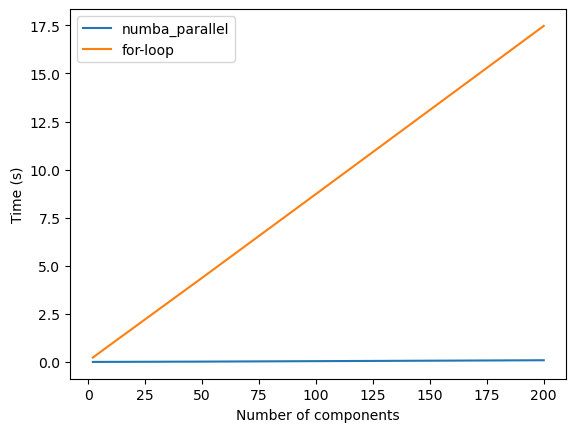

In [19]:
img = color.rgb2gray(data.astronaut())
u, s, vt = np.linalg.svd(img)
n_components = [2, 10, 50, 100, 200]
implementations = {
    'numba_parallel': rec_svd_nb_parallel,
    'for-loop': rec_loops
}
time_results = {}
for impl_name, impl_func in implementations.items():
    times = []
    for k in n_components:
        t_start = time()
        try:
            reco = impl_func(u, s, vt, k)
        except Exception as e:
            print(f'Error in {impl_name} for k={k}!')
            raise e
        t_end = time()
        t_elapsed = t_end - t_start
        times.append(t_elapsed)
        if impl_name not in time_results:
            time_results[impl_name] = {}
        time_results[impl_name][k] = t_elapsed
    print(f'{impl_name}: {times}')

plt.plot(n_components, [time_results['numba_parallel'][k] for k in n_components], label='numba_parallel')
plt.plot(n_components, [time_results['for-loop'][k] for k in n_components], label='for-loop')
plt.legend()
plt.xlabel('Number of components')
plt.ylabel('Time (s)')
plt.show()

<font color=red>
Numba ist ein Just-In-Time Compiler für Python, der darauf ausgelegt ist, Codeausführung zu optimieren. Er eignet sich besonders für numerische Operationen, was mit Bildern und ihrer Rekonstruktion der Fall ist. Der Decorator @nb.jit kann verwendet werden, um die Funktion mit Numba zu kompilieren und mit @nb.njit(parallel=True) zu parallelisieren.<br />
Es ist möglich den Code von den vorherigen Aufgaben mit Numba zu beschleunigen. Wir haben oben ein Beispiel wo wir Bilder mit SVD zerlegen, um sie dann wieder in ihre k Komponenten zu rekonstruieren. Dieses Beispiel wollen wir nutzen, um die Ausführungsgeschwindigkeit mit und ohne Numba zu analysieren.<br />
Die Funktion mit dem Numba Decorator "@nb.njit(parallel=True)" ermöglicht es uns die verschachtelten Schleifen zu paralleliseren. Um die verschachtelten Schleifen zu parallelisieren müssen die äusseren Schleifen unabhängig voneinander sein. Sind sie es nicht, kann dies zu fehlerhaften Resultaten führen.<br />
Der Speedup-Faktor für 50 Komponenten ist 5, für 100 Komponenten 8, d.h. während die Laufzeit für die Variante ohne Numba linear steigt, bleibt die Variante mit Numba konstant.
<font>

### 4 Parallelisierung mit Threads

Als nächstes Parallelisieren wir die Rekonstruktion der SVD zerlegten Matrizen mittels unterschiedlichen Thread-Varianten.

Links:
* Threading in Python ([Videokurs](https://realpython.com/courses/threading-python/), [Blogartikel](https://realpython.com/intro-to-python-threading/), [Quiz](https://realpython.com/quizzes/python-threading/)), RealPython
* https://github.com/eth-cscs/PythonHPC/tree/master/intro
* Slides vom Kurs kvanc zum Thema IPC mittels Python

#### 4.1 Einzelne Threads auf einer CPU

Implementiere eine Funktion, welche ein Rekonstruktionsschritt in Thread rekonstruiert. Wähle selbst welchen Schritt du mittels Threading implementierst. Verwende dabei geeignete Lock-Mechanismen. Verwende vor und nach den Lock-Mechanismen geeignete Print/Log-Statements und verwende unterschiedliche Farben der Print-Statements für die Threads. Validiere dein Ergebnis der Rekonstruktion indem du mehrere Threads für einzelne Rekonstruktionsschritte aufrufst.

In [20]:
### BEGIN SOLUTION

import threading

# Global lock for synchronization
lock = threading.Lock()

def reconstruct_step(matrix, step):
    # Performing reconstruction step
    u, s, vt = np.linalg.svd(matrix)
    reconstructed_matrix = rec_loops(u, s, vt, k=50)

    # Acquire the lock before printing
    with lock:
        color = colors.pop()
        print(color + threading.current_thread().name + " starting reconstruction step " + str(step))

    # Performing reconstruction step
    u, s, vt = np.linalg.svd(matrix)
    reconstructed_matrix = rec_loops(u, s, vt, k=50)

    # Acquire the lock before printing
    with lock:
        print(color + threading.current_thread().name + " completed reconstruction step " + str(step))

    return reconstructed_matrix


color_1 = "\033[94m"  # Blue
color_2 = "\033[92m"  # Green
color_3 = "\033[93m"  # Yellow
color_4 = "\033[91m"  # Red
colors = [color_1, color_2, color_3, color_4]

### END SOLUTION


In [21]:
### BEGIN SOLUTION

# Create multiple threads for individual reconstruction steps
threads = []
for step in range(1, 5):  # 4 reconstruction steps
    thread = threading.Thread(target=reconstruct_step, args=(img, step))
    threads.append(thread)
    thread.start()

for thread in threads:
    thread.join()

### END SOLUTION

Thread-6 (reconstruct_step) starting reconstruction step 2
Thread-7 (reconstruct_step) starting reconstruction step 3
Thread-5 (reconstruct_step) starting reconstruction step 1
Thread-8 (reconstruct_step) starting reconstruction step 4
Thread-6 (reconstruct_step) completed reconstruction step 2
Thread-5 (reconstruct_step) completed reconstruction step 1
Thread-7 (reconstruct_step) completed reconstruction step 3
Thread-8 (reconstruct_step) completed reconstruction step 4


#### 4.2 Bonus: Thread-Pool-Executor

Rufe zum Vergleich die unabhängige Rekonstruktionsschritte mittels eines Thread-Pool-Executors auf.

In [22]:
### BEGIN SOLUTION
### END SOLUTION

#### 4.3 Bonus: Threads auf mehreren CPUs

Verwende anstelle von Threading Multiprocessing damit die Threads auf mehrere CPUs verteilt werden.

Links:
* Concurrency [Blog](https://realpython.com/python-concurrency/), [Quiz](https://realpython.com/quizzes/python-concurrency/), RealPython


In [23]:
### BEGIN SOLUTION
### END SOLUTION

#### 4.4 Analyse

1. Macht es in diesem Beispiel Sinn Threads zu benutzen? Wann ist es sinnvoll Threads zu benutzen? Beschreibe in 2-3 Sätzen warum. 

<font color='red'>
Threads zu nutzen, um die Rekonstruktion von SVD zerlegten Matrizen zu parallelisieren, mag zu keinem signifikanten Leistungsanstieg führen. Der "Global Interpreter Lock" (GIL) in Python beschränkt die parallele Ausführung von CPU gebundenen Aufgaben innheralb der Threads. Threads eignen sich besser für I/O-gebundene Aufgaben oder Szenarien, in denen das Warten auf I/O-Operationen überlagert werden kann, so dass andere Threads mit der Ausführung fortfahren können. Ein konkretes Beispiel für ein solches Szenario wäre ein Webserver, der mehrere Client-Anfragen bearbeitet. Wenn ein Client eine Anfrage sendet, kann der Server einen Thread erstellen, der diese Anfrage bearbeitet, während andere Threads weiterhin auf neue Anfragen warten. 
</font>

1. Könnten in diesem Beispiel auch andere Code-Teile auf mehreren Threads aufgerufen werden? Welche würden sich eignen? Welche nicht? Beschreibe in 2-3 Sätzen warum. 

<font color='red'>
Geeignete Kandidaten für die Parallelisierung wären Operationen, die unabhängig sind und keine veränderbaren Daten gemeinsam nutzen. Ein Beispiel wäre die Durchführung einzelner SVD Berechnungen für separate Matrizen. Diese Aufgaben können gleichzeitig auf verschiedenen Threads ausgeführt werden, ohne dass es zu Konflikten kommt.
Andererseits eignen sich Aufgaben, die gemeinsame veränderbare Daten beinhalten und eine Synchronisierung erfordern, wie z.B. die Aktualisierung einer gemeinsamen Matrix oder die Durchführung von Berechnungen, die von Zwischenergebnissen abhängen, möglicherweise nicht für die parallele Ausführung mit Threads. Dies liegt daran, dass mehrere Threads, die gleichzeitig auf gemeinsame Daten zugreifen und diese ändern, zu Dateninkonsistenzen führen können.
</font>

1. Was sind die Unterschiede (auch bzgl. Leistung) der manuellen Ausführung des Threadings vs. dem Benutzen eines Thread-Pool-Executors oder von Multiprocessing?

<font color='red'>Manuelles Threading bietet eine personalisierte Steuerung, erreicht aber aufgrund der "Global Interpreter Lock" (GIL) möglicherweise keine echte Parallelisierung für CPU gebundene Aufgaben. Thread-Pool-Executors bieten eine einfacheres Interface und verbesserte Leistung durch die Wiederverwendung von Threads. Multiprocessing ermöglicht eine echte parallele Ausführung unter Verwendung separater Prozesse, führt aber zu zusätzlicher Komplexität für die Kommunikation zwischen den Prozessen. Die Wahl hängt von den spezifischen Anforderungen der Aufgabe ab.</font>